Dataset Shape: (569, 31)
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  wor

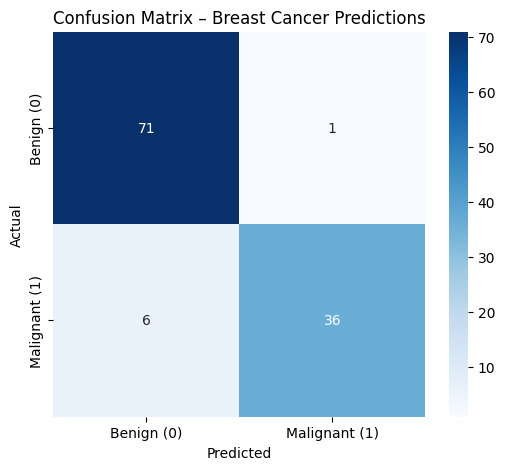

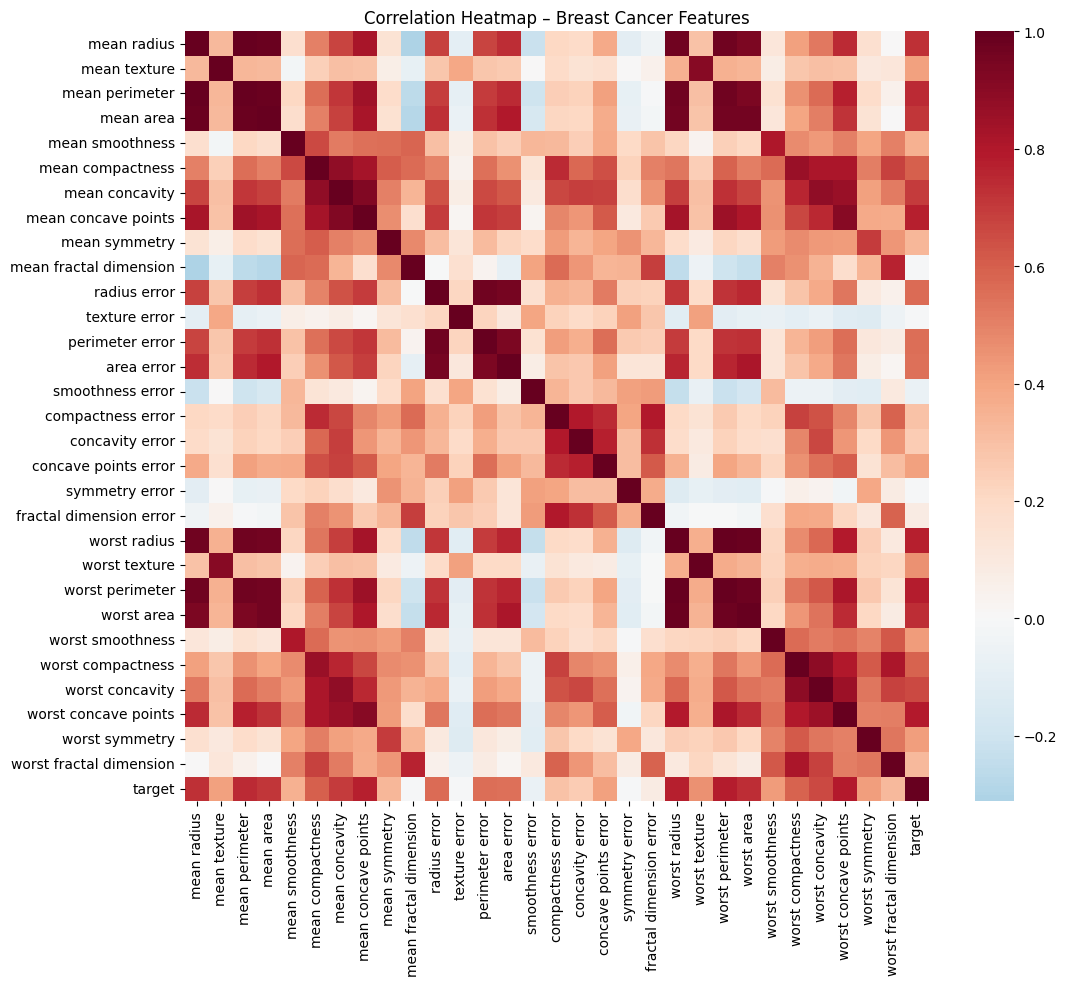

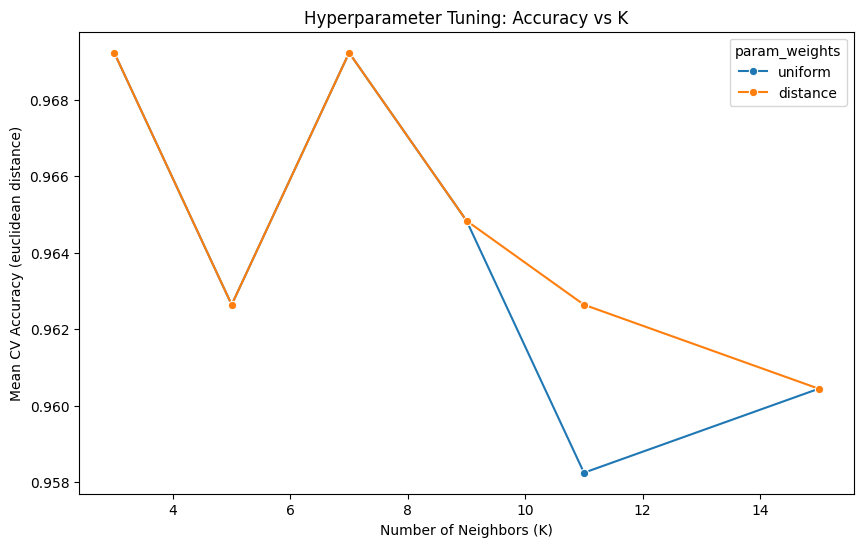

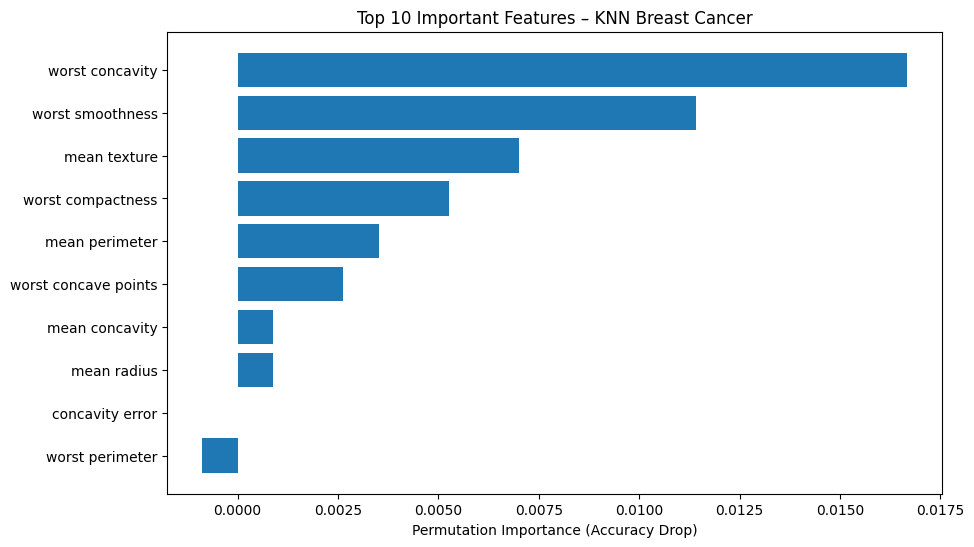

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

# =========================
# 1. Load Dataset
# =========================
# We use the sklearn loader to ensure it runs immediately,
# but this structure is identical to reading the Kaggle CSV.
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['diagnosis'] = data.target_names[data.target]  # columns: 'malignant' or 'benign'

# IF USING KAGGLE CSV FILE, UNCOMMENT BELOW:
# df = pd.read_csv("data.csv")
# df.drop(['Unnamed: 32'], axis=1, inplace=True) # Common Kaggle artifact

print("Dataset Shape:", df.shape)
print(df.head())

# =========================
# 2. Drop ID column (NOT a feature)
# =========================
if 'id' in df.columns:
    df = df.drop('id', axis=1)

# =========================
# 3. Encode Target (Classification)
# =========================
# The Kaggle dataset uses 'M' (Malignant) and 'B' (Benign).
# We encode them: Malignant = 1, Benign = 0
le = LabelEncoder()
df['target'] = le.fit_transform(df['diagnosis']) # Malignant becomes 1, Benign 0

X = df.drop(['diagnosis', 'target'], axis=1)
y = df['target']

# =========================
# 4. Train-Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================
# 5. Feature Scaling (MANDATORY for KNN)
# =========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================
# 6. KNN + Hyperparameter Tuning
# =========================
# We test different distance metrics (Euclidean vs Manhattan)
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}



knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", round(grid_search.best_score_, 4))

# =========================
# 7. Evaluation
# =========================
y_pred = best_model.predict(X_test_scaled)

print("\nFinal Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

# =========================
# 8. Confusion Matrix
# =========================
cm = confusion_matrix(y_test, y_pred)



plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Benign (0)', 'Malignant (1)'],
    yticklabels=['Benign (0)', 'Malignant (1)']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Breast Cancer Predictions")
plt.show()

# =========================
# 9. Correlation Heatmap
# =========================
# Note: The cancer dataset has 30 features, so this map will be dense
plt.figure(figsize=(12,10))
sns.heatmap(df.drop(['diagnosis'], axis=1).corr(), cmap='RdBu_r', center=0, annot=False)
plt.title("Correlation Heatmap – Breast Cancer Features")
plt.show()

# =========================
# 10. Accuracy vs Number of Neighbors (K)
# =========================
results_df = pd.DataFrame(grid_search.cv_results_)
# We filter to show only the metric that was chosen as "Best" to keep plot clean
best_metric = grid_search.best_params_['metric']
subset = results_df[results_df['param_metric'] == best_metric]

plt.figure(figsize=(10,6))
sns.lineplot(
    data=subset,
    x='param_n_neighbors',
    y='mean_test_score',
    hue='param_weights',
    marker='o'
)
plt.xlabel("Number of Neighbors (K)")
plt.ylabel(f"Mean CV Accuracy ({best_metric} distance)")
plt.title("Hyperparameter Tuning: Accuracy vs K")
plt.show()

# =========================
# 11. Permutation Feature Importance
# =========================
perm_importance = permutation_importance(
    best_model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42
)

# We take the top 10 most important features to avoid cluttering the plot
sorted_idx = perm_importance.importances_mean.argsort()[-10:]

plt.figure(figsize=(10,6))
plt.barh(
    X.columns[sorted_idx],
    perm_importance.importances_mean[sorted_idx]
)
plt.xlabel("Permutation Importance (Accuracy Drop)")
plt.title("Top 10 Important Features – KNN Breast Cancer")
plt.show()